# What is active statistical inference and should we care?

15 03 24

---

## Description

This notebook demonstrates some examples of the **active statistical inference** technique for obtaining unbiased estimates through a cleverly designed sampling process.

## Idea

Suppose we want to estimate a particular quantity from a dataset, for example, the prevalence of a particular condition among a human population. One way to do this is to take a random sample from the data and count the number of people in it who have the disease. 

This involves having someone 'label' each of the points that make up the random sample and often this labelling work is time-consuming. It is therefore desirable to have a method that leads to an estimate of the quantity of interest as accurately as possible with as points in the sample.

**Active statistical inference** involves using a trained model as a way of selecting points, rather than selecting them uniformly at random. This, in theory, leads to unbiased estimates of quantities with smaller variance than those obtained otherwise.


## Ingredients

- A training dataset $D_1 = {(x_1, y_1), (x_2, y_2), \ldots, (x_n, y_n)}$ consisting of examples $x_i$ and labels $y_i$
- A trained model (a classical statistical model or machine learning model), $f$ that takes inputs $x_i$ and produces predictions $\hat{y}_i := f(x_i)$ along with corresponding probabilities $p_i$.
- An unlabelled dataset $D_2 = {x_{n+1}, x_{n+2}, \ldots, x_{k+n}}$ consisting of $k$ examples that we want to label.
- A quantity $\theta$ to estimate from the unlabelled dataset

## Method
This notebook compares three approaches to estimating $\theta$:

1) A random sample of $m$ points from $D_2$

$$\hat{\theta} = \frac{1}{m}\sum_{i=1}^m y_i$$

And two active inference approaches. Each of these estimates $\theta$ as 

$$\hat{\theta} = \frac{1}{m}\sum_{i=1}^m \left( f(x_i) + (y_i - f(x_i))\frac{\xi_i}{\pi(x_i)}\right)$$

where:
- $\xi_i$ is equal to 1 only when the point $x_i$ has been selected to be labelled
- $\pi(x_i)$ is the probability of choosing point $x_i$

2) $\pi(x_i) = \frac{m}{N}$
3) $\pi(x_i) = \frac{u(x)}{\mathbb{E}(u(X))}\frac{m}{N}$, where $u(x)$ is the uncertainty of the model's prediction $f(x)$

## Questions

- Does this work for algorithms that are poorly calibrated?
- Is this method novel or simply rebranding by ML researchers of a stats technique?

## References

All of the code is based on the following paper:

- https://arxiv.org/abs/2403.03208

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# train a classifier
from sklearn.linear_model import LogisticRegression

sns.set()
%matplotlib inline

## 1. Create some data

In [125]:
# 1-D gaussians
n1 = 2048
n2 = 1024
N = n1 + n2

x1 = np.random.randn(n1)
x2 = np.random.randn(n2)-3
y1 = np.ones(n1)
y2 = np.zeros(n2)

x = np.concatenate([x1, x2])
y = np.concatenate([y1, y2])

df = pd.DataFrame(data={'x': x, 'y': y})

In [109]:
# create some test data
x1t = np.random.randn(n1)
x2t = np.random.randn(n2)-3
y1t = np.ones(n1)
y2t = np.zeros(n2)

xt = np.concatenate([x1t, x2t])
yt = np.concatenate([y1t, y2t])

dft = pd.DataFrame(data={'x': xt, 'y': yt})

## 2. Fit a logistic regression to the training data

In [110]:
clf = LogisticRegression()

clf.fit(x.reshape(-1, 1), y)

LogisticRegression()

## 3. Make some predictions

In [180]:
yt_probs = clf.predict_proba(xt.reshape(-1, 1))[:, 1]
yt_pred = clf.predict(xt.reshape(-1, 1))

# calculate the entropy as measure of uncertainty in prediction
dft['y_pred'] = yt_pred
dft['y_pred_prob'] = yt_probs

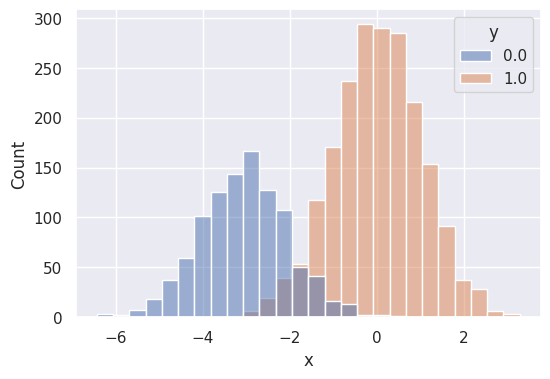

In [181]:
plt.figure(figsize=(6, 4))
sns.histplot(data=df, x='x', hue='y')
plt.show()

## 4. Sample schemes


### 4.1. Uniform random sampling

In [268]:
# take num_samples samples from the distribution
num_samples = 8192
sample_size = 64

sample_estimates1 = []

for n in range(num_samples):
    sample_estimates1.append(df.sample(sample_size).y.mean())

### 4.2. Active inference with all points chosen with equal probability

In [269]:
p = sample_size / N
p

0.020833333333333332

In [270]:
sample_estimates2 = []

for n in range(num_samples):
    indicators = np.random.binomial(1, p, N)
    dft['indicator'] = indicators
    # calculate the estimate
    subset = dft.query('indicator == 1')
    theta_1 = dft.y_pred.mean()
    theta_2 = (subset.y - subset.y_pred).sum() / sample_size
    theta = theta_1 + theta_2
    sample_estimates2.append(theta)

### 4.3. Active inference with points chosen based on the uncertainty in the model prediction

In [271]:
def u_good(q):
    return 2 * np.min([q, 1-q])

In [272]:
dft['u'] = [u_good(q) for q in dft.y_pred_prob]

In [273]:
# expected u
u_mean = dft['u'].mean()

In [274]:
sample_estimates3 = []

for n in range(num_samples):
    # for each of the points assign the probability
    dft['indicator_prob'] = dft['u'] / u_mean * sample_size / N
    dft['indicator2'] = [np.random.binomial(1, q) for q in dft['indicator_prob'].values]
    subset = dft.query('indicator2 == 1')
    theta_1 = dft.y_pred.mean()
    theta_2 = 1/N*((subset.y.values - subset.y_pred.values) / subset.indicator_prob.values).sum()
    theta = theta_1 + theta_2
    sample_estimates3.append(theta)

## 5. Final results

In [275]:
# show results from the different sampling schemes
all_samples = sample_estimates1 + sample_estimates2 + sample_estimates3
sample_labels = [0 for _ in range(len(sample_estimates1))] + [1 for _ in range(len(sample_estimates2))] + [2 for _ in range(len(sample_estimates2))]

In [276]:
df_results = pd.DataFrame(data={'estimate': all_samples, 'scheme': sample_labels})

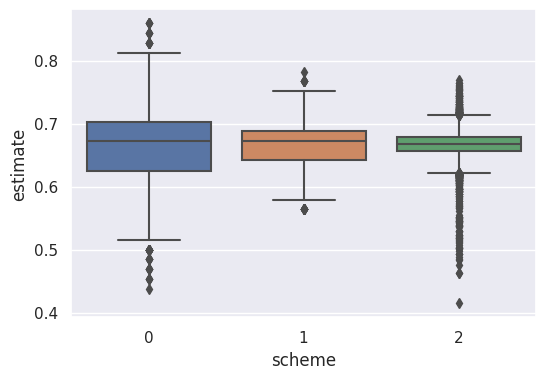

In [277]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_results, x='scheme', y='estimate')
plt.show()

/home/alex/.pyenv/versions/3.10.6/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 600x400 with 0 Axes>

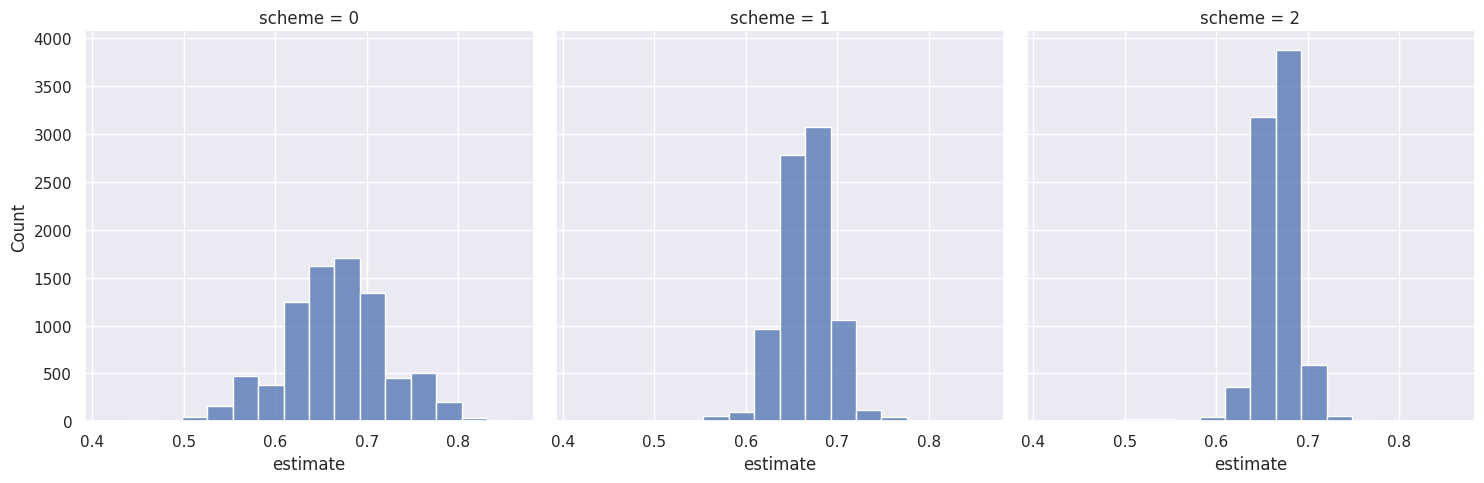

In [278]:
plt.figure(figsize=(6, 4))
sns.displot(data=df_results, 
            x='estimate', 
            col='scheme', 
            bins=16)
plt.show()

In [283]:
print(f"Scheme 1: average: {np.mean(sample_estimates1)}, mean: {np.sqrt(np.var(sample_estimates1))}")
print(f"Scheme 2: average: {np.mean(sample_estimates2)}, mean: {np.sqrt(np.var(sample_estimates2))}")
print(f"Scheme 3: average: {np.mean(sample_estimates3)}, mean: {np.sqrt(np.var(sample_estimates3))}")

Scheme 1: average: 0.6659870147705078, mean: 0.05791942979797631
Scheme 2: average: 0.6663468678792319, mean: 0.030137092900190253
Scheme 3: average: 0.6664579850527511, mean: 0.023245440844779083
